### Upper Confidence Bound (UCB)

The Upper Confidence Bound (UCB) acquisition function balances exploration and exploitation by assigning a score of $\mu + \sqrt{\beta} \cdot \sigma$ if the posterior distribution is normal with mean $\mu$ and variance $\sigma^2$. This "analytic" version is implemented in the `UpperConfidenceBound` class. The Monte Carlo version of UCB is implemented in the `qUpperConfidenceBound` class, which also allows for q-batches of size greater than one. (The derivation of q-UCB is given in Appendix A of [Wilson et. al., 2017](https://arxiv.org/pdf/1712.00424.pdf)).

### A scalarized version of q-UCB

Suppose now that we are in a multi-output setting, where, e.g., we model the effects of a design on multiple metrics. We first show a simple extension of the q-UCB acquisition function that accepts a multi-output model and performs q-UCB on a scalarized version of the multiple outputs, achieved via a vector of weights. Implementing a new acquisition function in botorch is easy; one simply needs to implement the constructor and a `forward` method.

In [1]:
import plotly.io as pio
# Ax uses Plotly to produce interactive plots. These are great for viewing and analysis,
# though they also lead to large file sizes, which is not ideal for files living in GH.
# Changing the default to `png` strips the interactive components to get around this.
pio.renderers.default = "png"

In [2]:
import math
from typing import Optional

from botorch.acquisition.monte_carlo import MCAcquisitionFunction
from botorch.models.model import Model
from botorch.sampling.samplers import MCSampler, SobolQMCNormalSampler
from botorch.utils import t_batch_mode_transform
from torch import Tensor


class qScalarizedUpperConfidenceBound(MCAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        beta: Tensor,
        weights: Tensor,
        sampler: Optional[MCSampler] = None,
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of
        # MCAcquisitionFunction performs some validity checks that we don't want here
        super(MCAcquisitionFunction, self).__init__(model=model)
        if sampler is None:
            sampler = SobolQMCNormalSampler(num_samples=512, collapse_batch_dims=True)
        self.sampler = sampler
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform()
    def forward(self, X: Tensor) -> Tensor:
        """Evaluate scalarized qUCB on the candidate set `X`.

        Args:
            X: A `(b) x q x d`-dim Tensor of `(b)` t-batches with `q` `d`-dim
                design points each.

        Returns:
            Tensor: A `(b)`-dim Tensor of Upper Confidence Bound values at the
                given design points `X`.
        """
        posterior = self.model.posterior(X)
        samples = self.sampler(posterior)  # n x b x q x o
        scalarized_samples = samples.matmul(self.weights)  # n x b x q
        mean = posterior.mean  # b x q x o
        scalarized_mean = mean.matmul(self.weights)  # b x q
        ucb_samples = (
            scalarized_mean + math.sqrt(self.beta * math.pi / 2) * (scalarized_samples - scalarized_mean).abs()
        )
        return ucb_samples.max(dim=-1)[0].mean(dim=0)

[pyKeOps]: Warning, no cuda detected. Switching to cpu only.


Note that `qScalarizedUpperConfidenceBound` is very similar to `qUpperConfidenceBound` and only requires a few lines of new code to accomodate scalarization of multiple outputs. The `@t_batch_mode_transform` decorator ensures that the input `X` has an explicit t-batch dimension (code comments are added with shapes for clarity).

See the end of this tutorial for a quick and easy way of achieving the same scalarization effect using `ScalarizedPosteriorTransform`.

#### Ad-hoc testing q-Scalarized-UCB

Before hooking the newly defined acquisition function into a Bayesian Optimization loop, we should test it. For this we'll just make sure that it properly evaluates on a compatible multi-output model. Here we just define a basic multi-output `SingleTaskGP` model trained on synthetic data.

In [3]:
import torch

from botorch.fit import fit_gpytorch_mll
from botorch.models import SingleTaskGP
from botorch.utils import standardize
from gpytorch.mlls import ExactMarginalLogLikelihood


# generate synthetic data
X = torch.rand(20, 2)
Y = torch.stack([torch.sin(X[:, 0]), torch.cos(X[:, 1])], -1)
Y = standardize(Y)  # standardize to zero mean unit variance

# construct and fit the multi-output model
gp = SingleTaskGP(X, Y)
mll = ExactMarginalLogLikelihood(gp.likelihood, gp)
fit_gpytorch_mll(mll)

# construct the acquisition function
qSUCB = qScalarizedUpperConfidenceBound(gp, beta=0.1, weights=torch.tensor([0.1, 0.5]))

In [4]:
# evaluate on single q-batch with q=3
qSUCB(torch.rand(3, 2))

tensor([0.5977], grad_fn=<MeanBackward1>)

In [5]:
# batch-evaluate on two q-batches with q=3
qSUCB(torch.rand(2, 3, 2))

tensor([0.3397, 0.7385], grad_fn=<MeanBackward1>)

### A scalarized version of analytic UCB (`q=1` only)

We can also write an *analytic* version of UCB for a multi-output model, assuming a multivariate normal posterior and `q=1`. The new class `ScalarizedUpperConfidenceBound` subclasses `AnalyticAcquisitionFunction` instead of `MCAcquisitionFunction`. In contrast to the MC version, instead of using the weights on the MC samples, we directly scalarize the mean vector $\mu$ and covariance matrix $\Sigma$ and apply standard UCB on the univariate normal distribution, which has mean $w^T \mu$ and variance $w^T \Sigma w$. In addition to the `@t_batch_transform` decorator, here we are also using `expected_q=1` to ensure the input `X` has a `q=1`.

*Note:* BoTorch also provides a `ScalarizedObjective` abstraction that can be used with any existing analytic acqusition functions and automatically performs the scalarization we implement manually below. See the end of this tutorial for a usage example.

In [6]:
from botorch.acquisition import AnalyticAcquisitionFunction


class ScalarizedUpperConfidenceBound(AnalyticAcquisitionFunction):
    def __init__(
        self,
        model: Model,
        beta: Tensor,
        weights: Tensor,
        maximize: bool = True,
    ) -> None:
        # we use the AcquisitionFunction constructor, since that of 
        # AnalyticAcquisitionFunction performs some validity checks that we don't want here
        super(AnalyticAcquisitionFunction, self).__init__(model)
        self.maximize = maximize
        self.register_buffer("beta", torch.as_tensor(beta))
        self.register_buffer("weights", torch.as_tensor(weights))

    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        """Evaluate the Upper Confidence Bound on the candidate set X using scalarization

        Args:
            X: A `(b) x d`-dim Tensor of `(b)` t-batches of `d`-dim design
                points each.

        Returns:
            A `(b)`-dim Tensor of Upper Confidence Bound values at the given
                design points `X`.
        """
        self.beta = self.beta.to(X)
        batch_shape = X.shape[:-2]
        posterior = self.model.posterior(X)
        means = posterior.mean.squeeze(dim=-2)  # b x o
        scalarized_mean = means.matmul(self.weights)  # b
        covs = posterior.mvn.covariance_matrix  # b x o x o
        weights = self.weights.view(1, -1, 1)  # 1 x o x 1 (assume single batch dimension)
        weights = weights.expand(batch_shape + weights.shape[1:])  # b x o x 1
        weights_transpose = weights.permute(0, 2, 1)  # b x 1 x o
        scalarized_variance = torch.bmm(
            weights_transpose, torch.bmm(covs, weights)
        ).view(batch_shape)  # b
        delta = (self.beta.expand_as(scalarized_mean) * scalarized_variance).sqrt()
        if self.maximize:
            return scalarized_mean + delta
        else:
            return scalarized_mean - delta

#### Ad-hoc testing Scalarized-UCB

Notice that we pass in an explicit q-batch dimension for consistency, even though `q=1`.

In [7]:
# construct the acquisition function
SUCB = ScalarizedUpperConfidenceBound(gp, beta=0.1, weights=torch.tensor([0.1, 0.5]))

In [8]:
# evaluate on single point
SUCB(torch.rand(1, 2))

tensor([0.2210], grad_fn=<AddBackward0>)

In [9]:
# batch-evaluate on 3 points
SUCB(torch.rand(3, 1, 2))

tensor([-0.4028,  0.3191, -0.2814], grad_fn=<AddBackward0>)

## Using the custom acquisition function with Ax's Service API

### Registering the new acquisition function

In order to use an acquisition function, Ax needs to know how to generate inputs to construct the acquisition function.

In [10]:
from typing import List
from typing import Any, Dict

from botorch.acquisition.input_constructors import acqf_input_constructor


@acqf_input_constructor(ScalarizedUpperConfidenceBound)
def construct_inputs_scalarized_ucb(
    model: Model,
    beta: float,
    weights: List[float],
    **kwargs: Any,
) -> Dict[str, Any]:
    return {
        "model": model,
        "beta": torch.as_tensor(beta, dtype=torch.double),
        "weights": torch.as_tensor(weights, dtype=torch.double),
    }

### Setting up a `GenerationStrategy` using `BOTORCH_MODULAR` with our custom acquistion function.

`BOTORCH_MODULAR` is a convenient wrapper implemented in Ax that facilitates the use of custom BoTorch models and acquisition functions in Ax experiments. In order to customize the way the candidates are generated, we need to construct a new `GenerationStrategy` and pass it into the `AxClient`.

In [11]:
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models


gs = GenerationStrategy(
    steps=[
        # Quasi-random initialization step
        GenerationStep(
            model=Models.SOBOL,
            num_trials=5,  # How many trials should be produced from this generation step
            model_kwargs={"seed": 999},  # Any kwargs you want passed into the model
        ),
        # Bayesian optimization step using the custom acquisition function
        GenerationStep(
            model=Models.BOTORCH_MODULAR,
            num_trials=-1,  # No limitation on how many trials should be produced from this step
            # For `BOTORCH_MODULAR`, we pass in kwargs to specify what surrogate or acquisition function to use.
            # `acquisition_options` specifies the set of additional arguments to pass into the input constructor.
            model_kwargs={
                "botorch_acqf_class": ScalarizedUpperConfidenceBound,
                "acquisition_options": {"beta": 0.1, "weights": [1.0, 1.0]},
            },
        ),
    ]
)

### Setting up the experiment

We will set up a simple experiment to optimize a simple scalarization of the BraninCurrin function (per the weights above). A detailed tutorial on Service API can be found [here](https://ax.dev/tutorials/gpei_hartmann_service.html).

In order to use the `GenerationStrategy` we just created, we will pass it into the `AxClient`.

In [12]:
from ax.service.ax_client import AxClient
from ax.service.utils.instantiation import ObjectiveProperties
from botorch.test_functions import BraninCurrin


# Initialize the client - AxClient offers a convenient API to control the experiment
ax_client = AxClient(generation_strategy=gs)
# Setup the experiment
ax_client.create_experiment(
    name="branincurrin_test_experiment",
    parameters=[
        {
            "name": f"x{i+1}",
            "type": "range",
            # It is crucial to use floats for the bounds, i.e., 0.0 rather than 0.
            # Otherwise, the parameter would 
            "bounds": [0.0, 1.0],
        }
        for i in range(2)
    ],
    objectives={
        "branin": ObjectiveProperties(minimize=True),
        "currin": ObjectiveProperties(minimize=True),
    },
)
# Setup a function to evaluate the trials
branincurrin = BraninCurrin()


def evaluate(parameters):
    x = torch.tensor([[parameters.get(f"x{i+1}") for i in range(2)]])
    bc_eval = branincurrin(x).squeeze().tolist()
    # In our case, standard error is 0, since we are computing a synthetic function.
    return {"branin": (bc_eval[0], 0.0), "currin": (bc_eval[1], 0.0)}

[INFO 03-10 14:54:47] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 03-10 14:54:47] ax.service.utils.instantiation: Due to non-specification, we will use the heuristic for selecting objective thresholds.
[INFO 03-10 14:54:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x1. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-10 14:54:47] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter x2. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 03-10 14:54:47] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='x1', parameter_type=

### Running the BO loop

Ax makes this part super simple!

In [13]:
for i in range(10):
    parameters, trial_index = ax_client.get_next_trial()
    # Local evaluation here can be replaced with deployment to external system.
    ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

[INFO 03-10 14:54:47] ax.service.ax_client: Generated new trial 0 with parameters {'x1': 0.62873, 'x2': 0.51481}.
[INFO 03-10 14:54:47] ax.service.ax_client: Completed trial 0 with data: {'branin': (46.244598, 0.0), 'currin': (6.842319, 0.0)}.
[INFO 03-10 14:54:47] ax.service.ax_client: Generated new trial 1 with parameters {'x1': 0.434883, 'x2': 0.396266}.
[INFO 03-10 14:54:47] ax.service.ax_client: Completed trial 1 with data: {'branin': (14.735401, 0.0), 'currin': (8.740173, 0.0)}.
[INFO 03-10 14:54:47] ax.service.ax_client: Generated new trial 2 with parameters {'x1': 0.075645, 'x2': 0.934926}.
[INFO 03-10 14:54:47] ax.service.ax_client: Completed trial 2 with data: {'branin': (2.808084, 0.0), 'currin': (4.10731, 0.0)}.
[INFO 03-10 14:54:47] ax.service.ax_client: Generated new trial 3 with parameters {'x1': 0.863245, 'x2': 0.038764}.
[INFO 03-10 14:54:47] ax.service.ax_client: Completed trial 3 with data: {'branin': (9.956846, 0.0), 'currin': (10.342199, 0.0)}.
[INFO 03-10 14:54:47

### Viewing trials and plotting the Pareto frontier

View the trials attached to the experiment.

In [14]:
ax_client.generation_strategy.trials_as_df

[INFO 03-10 14:54:49] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


,Generation Step,Generation Model,Trial Index,Trial Status,Arm Parameterizations
0,0,Sobol,0,COMPLETED,"{'0_0': {'x1': 0.63, 'x2': 0.51}}"
1,0,Sobol,1,COMPLETED,"{'1_0': {'x1': 0.43, 'x2': 0.4}}"
2,0,Sobol,2,COMPLETED,"{'2_0': {'x1': 0.08, 'x2': 0.93}}"
3,0,Sobol,3,COMPLETED,"{'3_0': {'x1': 0.86, 'x2': 0.04}}"
4,0,Sobol,4,COMPLETED,"{'4_0': {'x1': 0.95, 'x2': 0.81}}"
5,1,BoTorch,5,COMPLETED,"{'5_0': {'x1': 1.0, 'x2': 0.34}}"
6,1,BoTorch,6,COMPLETED,"{'6_0': {'x1': 0.55, 'x2': 0.0}}"
7,1,BoTorch,7,COMPLETED,"{'7_0': {'x1': 0.12, 'x2': 0.0}}"
8,1,BoTorch,8,COMPLETED,"{'8_0': {'x1': 0.05, 'x2': 0.0}}"
9,1,BoTorch,9,COMPLETED,"{'9_0': {'x1': 0.12, 'x2': 0.03}}"


Plot the Pareto frontier.

Note that we do not expect a good coverage of the Pareto frontier since we use very small number of evaluations and our acquisition function naively optimizes the sum of the two objectives.

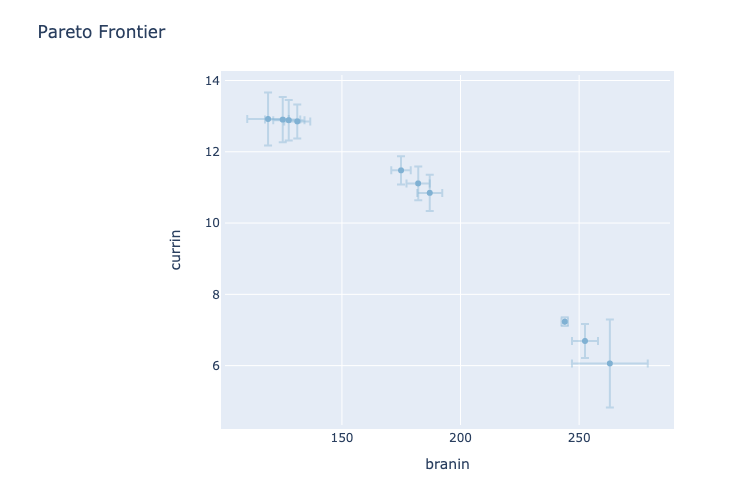

In [15]:
from ax.plot.pareto_frontier import plot_pareto_frontier
from ax.plot.pareto_utils import compute_posterior_pareto_frontier
from ax.utils.notebook.plotting import render


objectives = ax_client.experiment.optimization_config.objective.objectives
frontier = compute_posterior_pareto_frontier(
    experiment=ax_client.experiment,
    data=ax_client.experiment.fetch_data(),
    primary_objective=objectives[1].metric,
    secondary_objective=objectives[0].metric,
    absolute_metrics=["branin", "currin"],
)
render(plot_pareto_frontier(frontier, CI_level=0.90))

### Appendix: Using `ScalarizedPosteriorTransform`

Using the `ScalarizedPosteriorTransform` abstraction, the functionality of `ScalarizedUpperConfidenceBound` implemented above can be easily achieved in just a few lines of code. `PosteriorTransform`s can be used with both the MC and analytic acquisition functions.

In [16]:
from botorch.acquisition.objective import ScalarizedPosteriorTransform
from botorch.acquisition.analytic import UpperConfidenceBound

pt = ScalarizedPosteriorTransform(weights=torch.tensor([0.1, 0.5]))
SUCB = UpperConfidenceBound(gp, beta=0.1, posterior_transform=pt)